# Data analysis and pretraitment for the DLMI challenge

In [1]:
import h5py
import torch
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
import torchvision.models as models

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/DLMI_challenge')

Mounted at /content/drive


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() # for Nvidia GPU users
                      else 'mps' if torch.backends.mps.is_available() # for MacOS MPS users
                      else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
TRAIN_IMAGES_PATH = 'data/train.h5'
VAL_IMAGES_PATH = 'data/val.h5'
TEST_IMAGES_PATH = 'data/test.h5'
SEED = 0

In [5]:
torch.random.manual_seed(SEED)
random.seed(SEED)

## Data extraction and storage

```
├── idx           # index of the image
│   └── img       # image in a tensor format
│   └── label     # binary label of the image
│   └── metadata  # some metadata on the images
```

In [6]:
train_images = {0: {0: None, 1: None},
                3: {0: None, 1: None},
                4: {0: None, 1: None}}
val_images = {1: {0: None, 1: None}}

In [7]:
for img_data, data_path in zip([train_images, val_images], [TRAIN_IMAGES_PATH, VAL_IMAGES_PATH]):
    with h5py.File(data_path, 'r') as hdf:
        for img_idx in list(hdf.keys()):
            label = int(np.array(hdf.get(img_idx).get('label')))
            center = int(np.array(hdf.get(img_idx).get('metadata'))[0])
            if img_data[center][label] is None:
                img_data[center][label] = np.array(hdf.get(img_idx).get('img'))
            if all(all(value is not None for value in inner_dict.values()) for inner_dict in img_data.values()):
                break

all_data = {**train_images, **val_images}

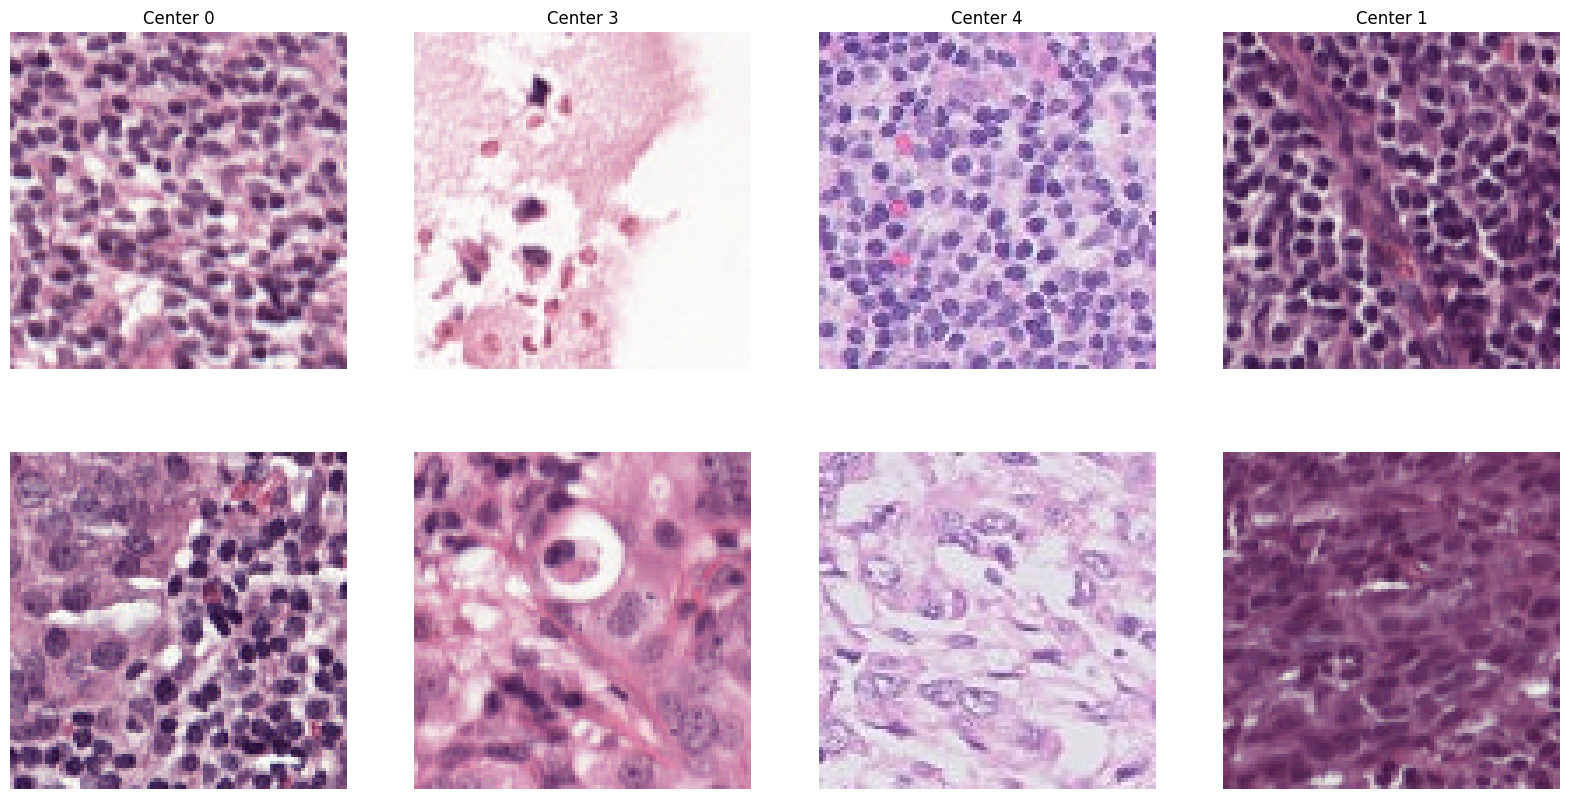

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
center_ids = {center: idx for idx, center in enumerate(all_data.keys())}
for center in all_data:
    for label in all_data[center]:
        axs[label, center_ids[center]].imshow(np.moveaxis(all_data[center][label], 0, -1).astype(np.float32))
        axs[label, center_ids[center]].axis('off')
        if label == 0:
            axs[label, center_ids[center]].set_title(f'Center {center}')
plt.show()

In [9]:
with h5py.File(TRAIN_IMAGES_PATH, 'r') as hdf:
    records = []
    for img_idx in hdf.keys():
        label = int(np.array(hdf.get(img_idx).get('label')))
        center = int(np.array(hdf.get(img_idx).get('metadata'))[0])

        records.append({'index': img_idx, 'center': center, 'label': label})

train_dataframe = pd.DataFrame(records) # We store the idx of each img with metadatas.

df_counts = train_dataframe.groupby(['center', 'label']).size().reset_index(name='count').pivot(index='center', columns='label', values='count').fillna(0).astype(int)
df_counts['total'] = df_counts.sum(axis=1)
df_counts

label       0      1  total
center                     
0        8815   8941  17756
3       19293  19463  38756
4       21672  21816  43488

Regarding the centers, the `Training Dataset` is unbalanced. There is a huge difference in the number of images per center enven if there is an even repartition between classes.

# Data visualisation

In [10]:
!pip install torchstain

In [11]:
from src.visualization import HistopathologyDataset,extract_structural_features, get_features_from_model, plot_tSNE

import torchstain
from torchvision.transforms import v2
from torch.utils.data import random_split

In this part we will see, using a ResNET feature extractor and t-SNE clustering, if we can extract the center information based on the image.

### Visualization of raw data

Let's first check our raw data and if we can see any problem with them.

In [12]:
base_set = HistopathologyDataset(TRAIN_IMAGES_PATH,
                         transforms=v2.Compose([
                             v2.ToPILImage(),
                             v2.Resize((224, 224)),
                             v2.ToImage(),
                             v2.ToDtype(torch.float32, scale=True)
                             ]),
                          name='train')

base_set_small, _ = random_split(base_set, [0.3, 0.7], generator=torch.Generator().manual_seed(SEED))

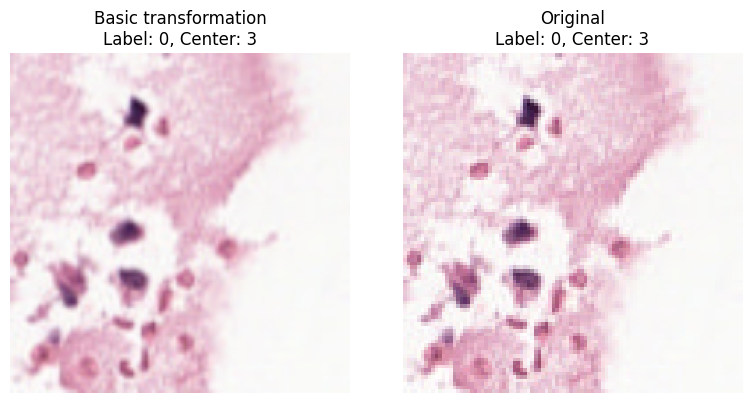

In [13]:
dummy_set = HistopathologyDataset(TRAIN_IMAGES_PATH,
                          name='train')

index = 0

img, label, center = base_set[index]
true_img, true_label, true_center = dummy_set[index]

# Créer les subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Image 1 (ex: transformée)
axes[0].imshow(TF.to_pil_image(img))
axes[0].set_title(f"Basic transformation\nLabel: {label}, Center: {center}")
axes[0].axis('off')

# Image 2 (ex: image d'origine)
axes[1].imshow(TF.to_pil_image(true_img))
axes[1].set_title(f"Original\nLabel: {true_label}, Center: {true_center}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
struct_features = extract_structural_features(base_set_small, batch_size=128, device=device)

  0%|          | 0/235 [00:00<?, ?it/s]

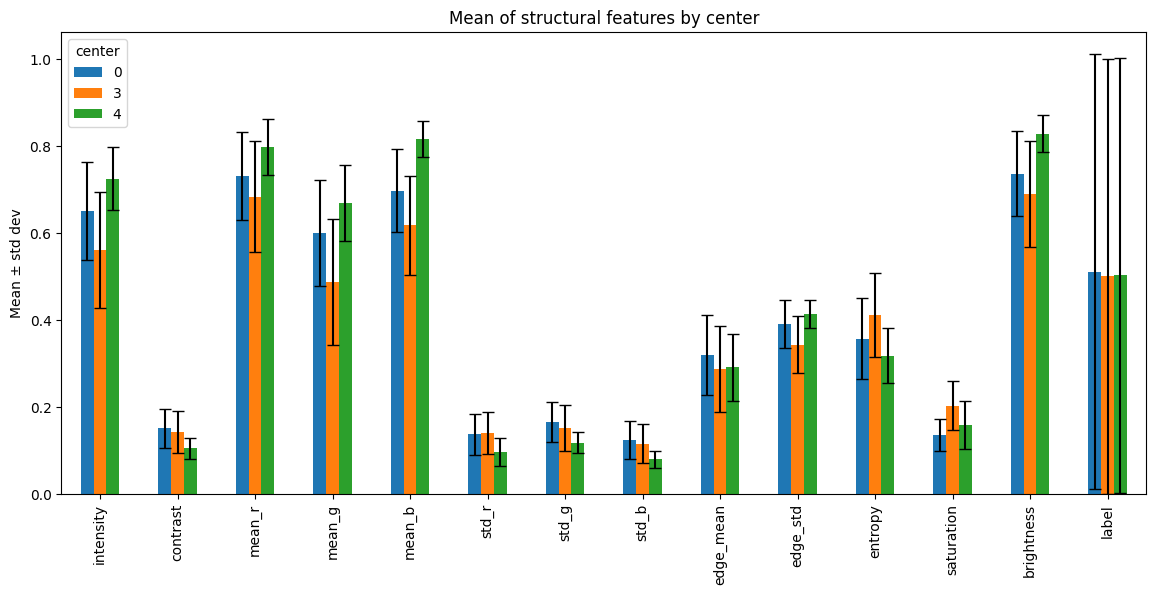

In [ ]:
# Calculate the mean and standard deviation grouped by 'center'
means = struct_features.groupby("center").mean().T
stds = struct_features.groupby("center").std().T

# Plot with error bars (standard deviation)
ax = means.plot.bar(
    figsize=(14, 6),
    yerr=stds,              # This adds the std dev as error bars
    capsize=4,              # Optional: adds caps on error bars
    legend=True,
    title="Mean of structural features by center",
    ylabel="Mean ± std dev",
)

We observe a significant variation in image specifications across different centers. This discrepancy may lead the model to rely on these specifications rather than the actual image content to perform the classification task. To investigate this, we will use a ResNet50 pretrained on ImageNet to extract features from the images, and then apply the t-SNE dimensionality reduction technique. If the resulting visualization shows clear clustering by center, it would suggest that the model is indeed capturing and relying on image specifications rather than intrinsic visual features.

#### features extraction using a ResNET50 and display via t-SNE

In [ ]:
base_features = get_features_from_model(models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
                            base_set_small,
                            device=device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 223MB/s]


  0%|          | 0/938 [00:00<?, ?batch/s]

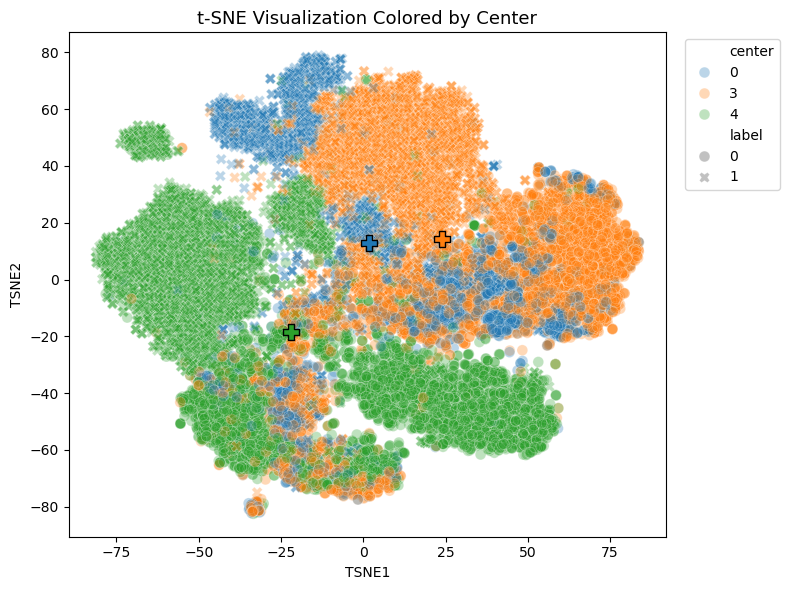

In [ ]:
plot_tSNE(base_features)

Here, we observe that the model tends to learn features based on image specifications, as evidenced by the clear separation between centers. However, we can also notice that infected tissues are mostly located in the top-left region, while healthy tissues are clustered in the bottom-right. This suggests that some level of class-relevant information is still being captured. To mitigate the domain shift between centers—which may cause the model to overly focus on image specs—we need to apply appropriate preprocessing to reduce this bias.

## Data pre-traitment

For preprocessing, we apply stain normalization using either the [Reinhard](https://ieeexplore.ieee.org/document/946629) or the [Macenko](https://ieeexplore.ieee.org/document/5193250) method. These techniques enable us to reduce color variability caused by differences in staining protocols across centers. [Reinhard](https://ieeexplore.ieee.org/document/946629) normalization works by matching the color distribution of an image to that of a target in the LAB color space, while [Macenko](https://ieeexplore.ieee.org/document/5193250) normalization relies on a statistical analysis of the stain vectors using optical density space. Both approaches help standardize image appearance by aligning it to the specifications of a chosen reference image.

In [89]:
class StainNormalize:
    def __init__(self, target_image_tensor, backend='torch', method='reinhard'):

        if method not in ['reinhard', 'macenko']:
            raise ValueError("Method must be either 'reinhard' or 'macenko'")
        self.method = method

        self.normalizer_rein = torchstain.normalizers.reinhard.ReinhardNormalizer(backend=backend)
        self.normalizer_mac = torchstain.normalizers.macenko.MacenkoNormalizer(backend=backend)

        # Fit the normalizer to the target image
        self.normalizer_rein.fit(target_image_tensor)
        self.normalizer_mac.fit(target_image_tensor)

    def __call__(self, img):
        # img is expected to be a tensor in [0,1], shape [C,H,W]
        # torchstain expects range [0, 255]
        img = img.clone().detach()
        img = img * 255.0

        if self.method == 'macenko':
            try:
                norm_img, _, _ = self.normalizer_mac.normalize(I=img, stains=True)
            except Exception as e:
                norm_img = self.normalizer_rein.normalize(I=img)
        else:
            norm_img = self.normalizer_rein.normalize(I=img)

        return norm_img.permute(2, 0, 1).float() / 255.0


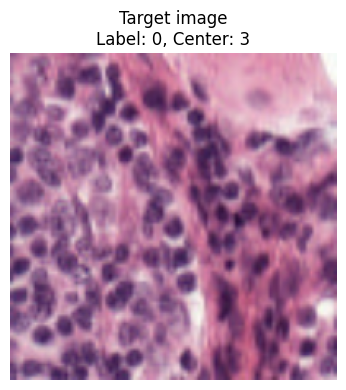

In [129]:
# We choose a target image to fit the stain normalizer
# This image will be used to normalize all other images in the dataset
target_idx = train_dataframe[train_dataframe['center'] == 3].sample(1, random_state=SEED+15)['index'].values[0]

# Define the transform for the target image to matches the input size of the model
target_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224,224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

# Open the HDF5 file in read mode
with h5py.File(TRAIN_IMAGES_PATH, 'r', swmr=True) as hdf :

    # Read the target image from the HDF5 file, apply the transform and multiply the image by 255.0
    target_img = torch.from_numpy(hdf[target_idx]['img'][()]).float()
    target_img =(target_transform(target_img)*255.0).to(torch.uint8)

    # display of the target image selected for stain normalization
    fig, axes = plt.subplots(1, 1, figsize=(8, 4))

    label = hdf[target_idx]['label'][()]
    center = hdf[target_idx]['metadata'][()][0]

    axes.imshow(TF.to_pil_image(target_img/255.0))
    axes.set_title(f"Target image\nLabel: {label}, Center: {center}")
    axes.axis('off')

    plt.tight_layout()
    plt.show()

We chose to normalize our dataset using an image from the third center, as it exhibits the lowest overall intensity. This helps ensure that the normalization process does not amplify stain variations and provides a more conservative reference across centers.

In [130]:
# Setup the stain normalizer with the target image
stain_normalizer = StainNormalize(target_image_tensor=target_img, backend='torch')

stain_transform = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    stain_normalizer
])

stained_dataset = HistopathologyDataset(TRAIN_IMAGES_PATH,
                              transforms = stain_transform,
                              name = 'train')

Let's see how our data is transformed :

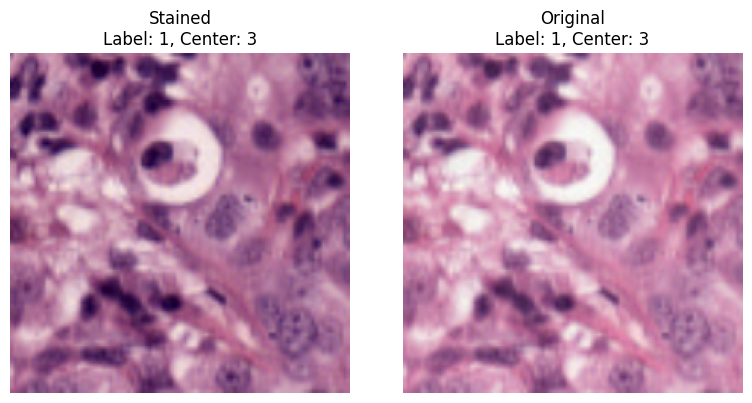

In [134]:
dummy_set = HistopathologyDataset(TRAIN_IMAGES_PATH,
                          transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()]),
                          name='train')

index = 3

img, label, center = stained_dataset[index]
true_img, true_label, true_center = dummy_set[index]

# Créer les subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Image 1 (ex: transformée)
axes[0].imshow(TF.to_pil_image(img))
axes[0].set_title(f"Stained\nLabel: {label}, Center: {center}")
axes[0].axis('off')

# Image 2 (ex: image d'origine)
axes[1].imshow(TF.to_pil_image(true_img))
axes[1].set_title(f"Original\nLabel: {true_label}, Center: {true_center}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

As expected, the normalized image retains the original structure but appears darker. Additionally, the stain normalization process enhances the contrast of the nuclear regions, making the nuclei more prominent and easier to distinguish.
We now propose to apply the same procedure in order to visualize structural differences between centers.

In [135]:
little_stain_dataset, _ = random_split(stained_dataset, [0.3, 0.7], generator=torch.Generator().manual_seed(SEED))

In [136]:
stained_features = extract_structural_features(little_stain_dataset, batch_size=16, device=device)

  0%|          | 0/1875 [00:00<?, ?it/s]

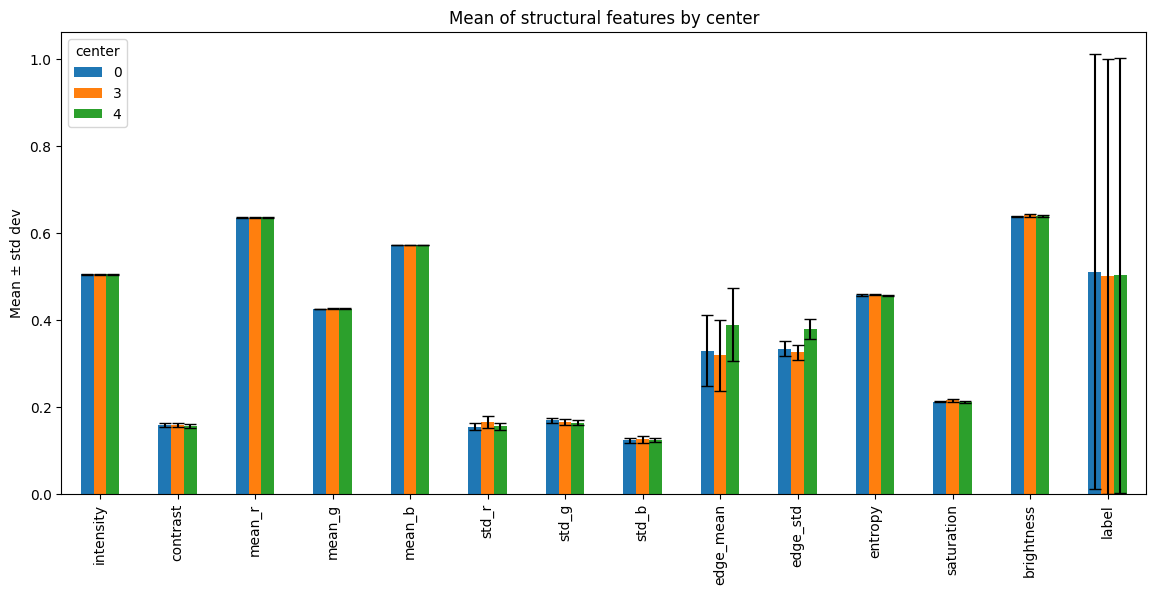

In [137]:
# Calculate the mean and standard deviation grouped by 'center'
means = stained_features.groupby("center").mean().T
stds = stained_features.groupby("center").std().T

# Plot with error bars (standard deviation)
ax = means.plot.bar(
    figsize=(14, 6),
    yerr=stds,              # This adds the std dev as error bars
    capsize=4,              # Optional: adds caps on error bars
    legend=True,
    title="Mean of structural features by center",
    ylabel="Mean ± std dev",
)

Here we can see clearly that our transformation method enable us to normalize our dataset to the same specs. As a result, all centers now share the same image characteristics.

  0%|          | 0/1875 [00:00<?, ?batch/s]

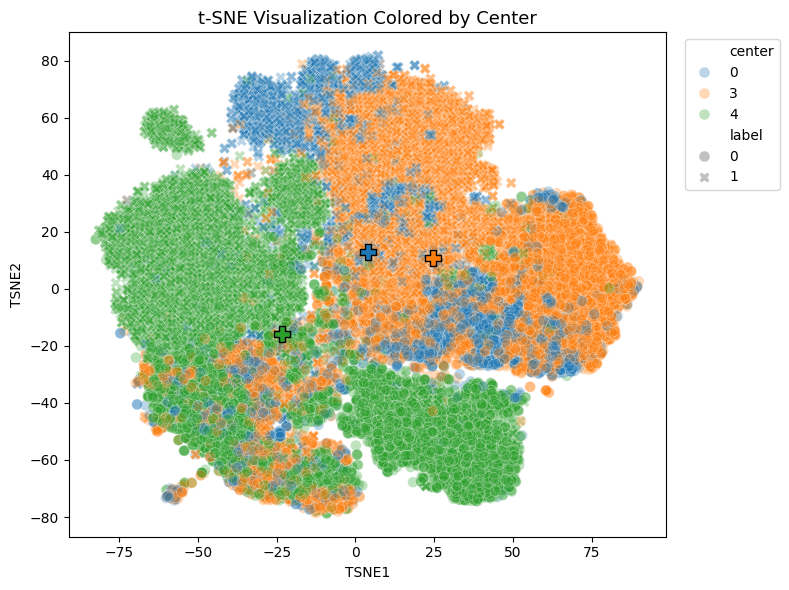

In [138]:
stained_features_from_resnet = get_features_from_model(models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
                            little_stain_dataset,
                            device=device,
                            batch_size=16)
plot_tSNE(stained_features_from_resnet)

# Conclusion :
In conclusion, our transformation method allows us to normalize the dataset to the specifications of a target image selected from the second most represented center. This preprocessing strategy reduces inter-center variability and ensures that the model focuses on learning relevant biological patterns—such as identifying wounded nuclei—rather than being biased by structural or staining differences across centers.

# Annexe

In [ ]:
from PIL import Image, ImageOps
from torchvision.transforms.v2 import functional as F
from torchvision.transforms.v2.functional import to_tensor
import torchvision.transforms.functional as TF

In [ ]:
# 1. Equalize histogram (à la PIL)
class EqualizePIL:
    def __call__(self, img):
        if not isinstance(img, Image.Image):
            img = TF.to_pil_image(img)
        return ImageOps.equalize(img)

# 2. Conditional Alpha Blending based on intensity
class ConditionalAlphaBlending:
    def __init__(self, threshold=0.6, alpha=0.4, blend_color=(0.5, 0.5, 0.5)):
        self.threshold = threshold
        self.alpha = alpha
        self.blend_color = torch.tensor(blend_color).view(3, 1, 1)

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = TF.to_tensor(img)  # [0, 1]
        luminance = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
        mean_intensity = luminance.mean().item()
        if mean_intensity > self.threshold:
            img = self.alpha * img + (1 - self.alpha) * self.blend_color.to(img.device)
        return img.clamp(0, 1)

# 3. Brightness Normalizer: scale intensity to target mean
class BrightnessNormalizer:
    def __init__(self, target_mean=0.5):
        self.target_mean = target_mean

    def __call__(self, img):
        if isinstance(img, Image.Image):
            img = TF.to_tensor(img)  # [0, 1]
        current_mean = img.mean()
        if current_mean > 0:
            img = img * (self.target_mean / current_mean)
        return img.clamp(0, 1)

In [ ]:
imagenet_invariant_transform = v2.Compose([
    v2.ToPILImage(),  # Requis pour ImageOps
    EqualizePIL(),  # Histogram Equalization
    v2.Pad(1),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  # Donne un tensor [0,1]
    ConditionalAlphaBlending(threshold=0.6, alpha=0.4),
    BrightnessNormalizer(target_mean=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                 std=[0.229, 0.224, 0.225]),  # ImageNet std
])

modified_set_1 = HistopathologyDataset(TRAIN_IMAGES_PATH,
                             transforms = imagenet_invariant_transform,
                             name = 'train')

In [ ]:
transform = v2.Compose([
    v2.ToPILImage(),
    v2.Pad(1),
    v2.Resize((224, 224)),
    v2.ColorJitter(brightness=.5, hue=.3),
    v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet mean
        std=[0.229, 0.224, 0.225]    # ImageNet std
    )
])

modified_set_2 = HistopathologyDataset(TRAIN_IMAGES_PATH,
                             transforms = transform,
                             name = 'train')

In [ ]:
modified_struct_features = extract_structural_features(modified_set_1, batch_size=64, device=device)

  0%|          | 0/1563 [00:00<?, ?it/s]

<Axes: title={'center': 'Moyennes des features par centre'}>

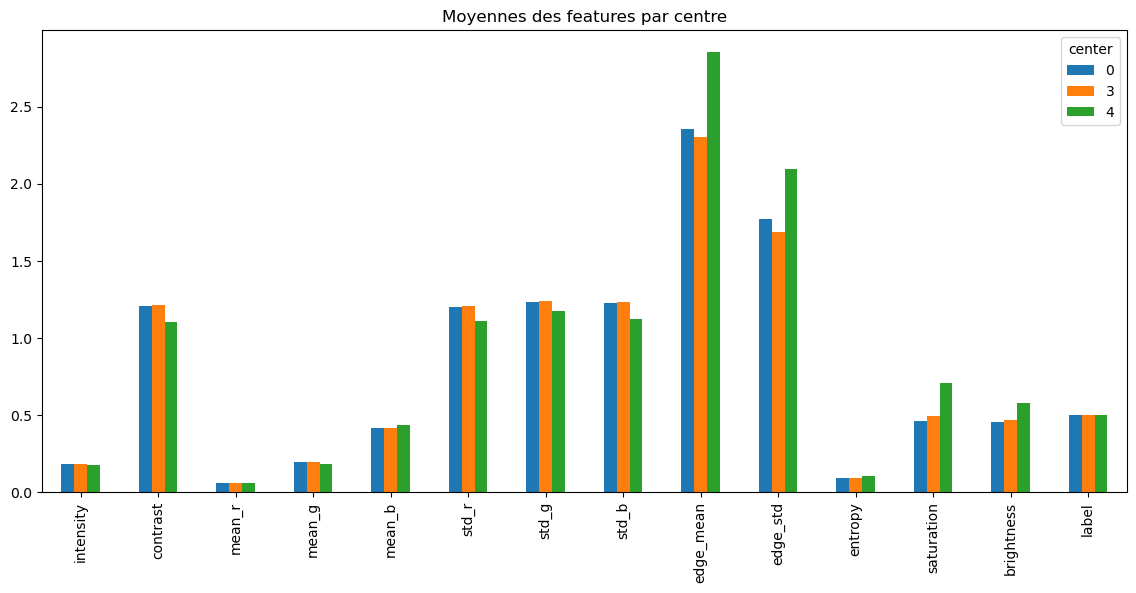

In [ ]:
modified_struct_features.groupby("center").mean().T.plot.bar(figsize=(14,6), legend=True, title="Moyennes des features par centre")

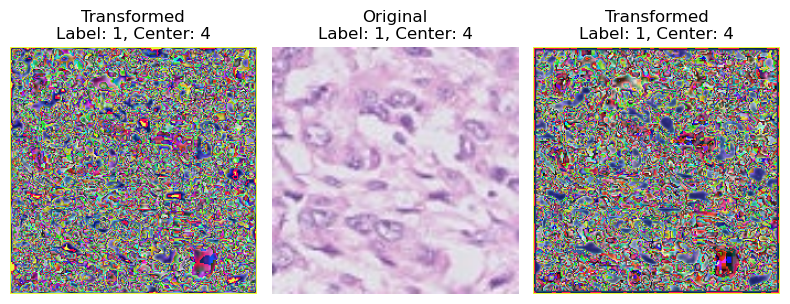

In [ ]:
index = 2

img, label, center = modified_set_1[index]
img2, label2, center2 = modified_set_2[index]
true_img, true_label, true_center = dummy_set[index]

# Créer les subplots
fig, axes = plt.subplots(1, 3, figsize=(8, 4))

# Image 1 (ex: transformée)
axes[0].imshow(TF.to_pil_image(img))
axes[0].set_title(f"Transformed\nLabel: {label}, Center: {center}")
axes[0].axis('off')

# Image 1 (ex: transformée)
axes[2].imshow(TF.to_pil_image(img2))
axes[2].set_title(f"Transformed\nLabel: {label2}, Center: {center2}")
axes[2].axis('off')

# Image 2 (ex: image d'origine)
axes[1].imshow(TF.to_pil_image(true_img))
axes[1].set_title(f"Original\nLabel: {true_label}, Center: {true_center}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/3125 [00:00<?, ?batch/s]

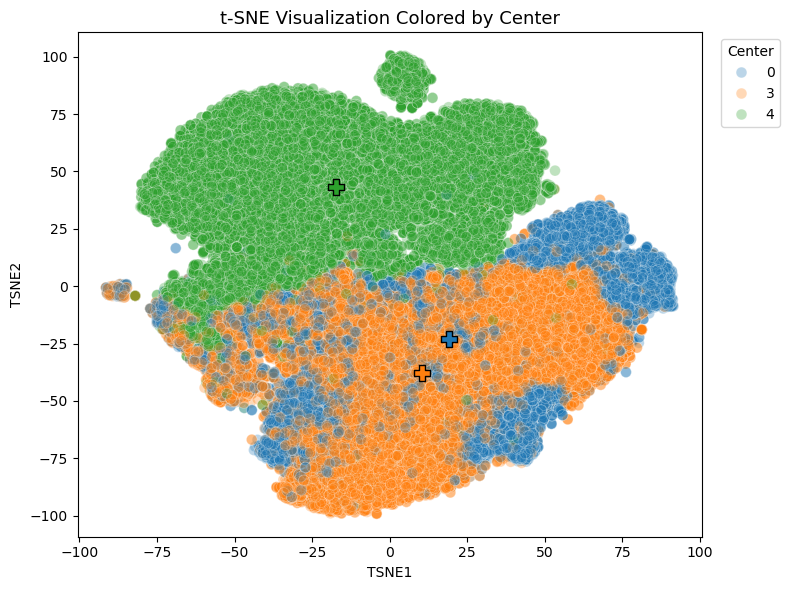

In [ ]:
modified_features_df = get_features_from_model(models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
                            modified_set_1,
                            device=device)

plot_tSNE(modified_features_df)

### Data transformation \#2

In [ ]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transforms = v2.Compose([
    v2.Resize((256, 256)),                      # Resize to a common size
    v2.RandomResizedCrop(224, scale=(0.8, 1.0)), # Same size as ImageNet input
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02), # Normalize appearance
    v2.RandomAutocontrast(p=0.5),               # Normalize dynamic range
    v2.RandomEqualize(p=0.3),                   # Histogram equalization
    v2.ToImage(),                               # Required for v2 transforms
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [ ]:
modified_set_3 = HistopathologyDataset(TRAIN_IMAGES_PATH,
                               transforms=train_transforms,
                                 name='train')

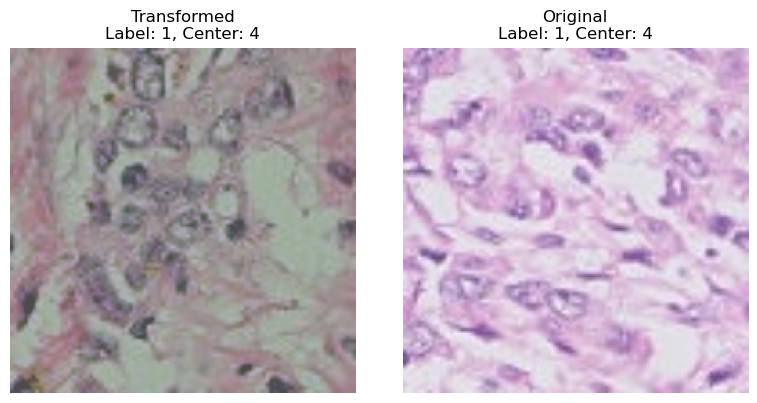

In [ ]:
dummy_set = HistopathologyDataset(TRAIN_IMAGES_PATH,
                          transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()]),
                          name='train')

index = 2

img, label, center = modified_set_3[index]
true_img, true_label, true_center = dummy_set[index]

# Créer les subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Image 1 (ex: transformée)
axes[0].imshow(TF.to_pil_image(img))
axes[0].set_title(f"Transformed\nLabel: {label}, Center: {center}")
axes[0].axis('off')

# Image 2 (ex: image d'origine)
axes[1].imshow(TF.to_pil_image(true_img))
axes[1].set_title(f"Original\nLabel: {true_label}, Center: {true_center}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/782 [00:00<?, ?it/s]

<Axes: title={'center': 'Moyennes des features par centre'}>

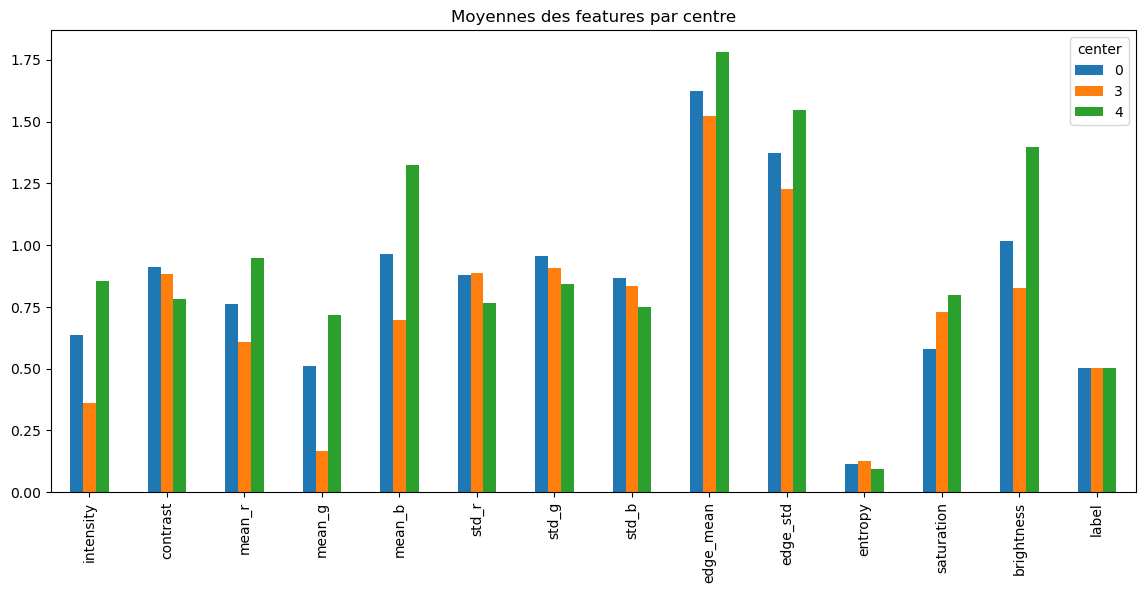

In [ ]:
modified_struct_features_2 = extract_structural_features(modified_set_3, batch_size=128, device=device)
modified_struct_features_2.groupby("center").mean().T.plot.bar(figsize=(14,6), legend=True, title="Moyennes des features par centre")

  0%|          | 0/3125 [00:00<?, ?batch/s]

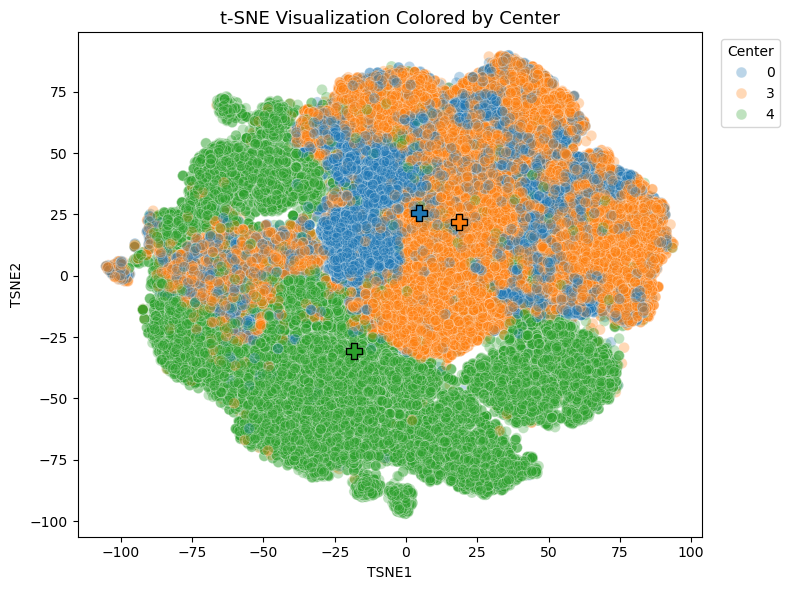

In [ ]:
modified_features_df_2 = get_features_from_model(models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
                            modified_set_2,
                            device=device)

plot_tSNE(modified_features_df_2)

###  Data transformation \#3

In [ ]:
class NormalizeIntensity(torch.nn.Module):
    def __init__(self, min_percentile=0.5, max_percentile=99.5):
        super().__init__()
        self.min_percentile = min_percentile
        self.max_percentile = max_percentile

    def forward(self, image: torch.Tensor) -> torch.Tensor:
        """
        image: torch.Tensor of shape (C, H, W) with float values in [0, 1]
        """
        image_np = image.numpy()

        # Compute per-channel percentiles (C, 1, 1) shape
        min_vals = np.percentile(image_np, self.min_percentile, axis=(1, 2), keepdims=True)
        max_vals = np.percentile(image_np, self.max_percentile, axis=(1, 2), keepdims=True)

        norm_image = (image_np - min_vals) / (max_vals - min_vals + 1e-8)
        norm_image = np.clip(norm_image, 0, 1)

        return torch.from_numpy(norm_image).type_as(image)

class ConditionalAlphaBlending:
    def __init__(self, threshold=0.6, alpha=0.4, blend_color=(0.5, 0.5, 0.5)):
        self.threshold = threshold
        self.alpha = alpha
        self.blend_color = torch.tensor(blend_color).view(3, 1, 1)

    def __call__(self, img):
        # Convert to tensor if input is PIL
        if isinstance(img, Image.Image):
            img = TF.to_tensor(img)  # tensor [C, H, W] in [0, 1]

        # Compute perceptual luminance
        luminance = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
        mean_intensity = luminance.mean().item()

        if mean_intensity > self.threshold:
            # Blend with neutral color (default = mid-gray)
            img = self.alpha * img + (1 - self.alpha) * self.blend_color.to(img.device)

        return img.clamp(0, 1)

In [ ]:
transform3 = v2.Compose([
    v2.ToPILImage(),
    v2.Resize((224, 224)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    NormalizeIntensity(min_percentile=0.05, max_percentile=99.95),
    ConditionalAlphaBlending(threshold=0.4, alpha=0.5),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

modified_set_3 = HistopathologyDataset(TRAIN_IMAGES_PATH,
                                 transforms=transform3,
                                 name='train')

In [ ]:
train_size = int(0.2 * len(modified_set_3))
val_size = len(modified_set_3) - train_size

train_dataset, val_dataset = random_split(modified_set_3, [train_size, val_size])

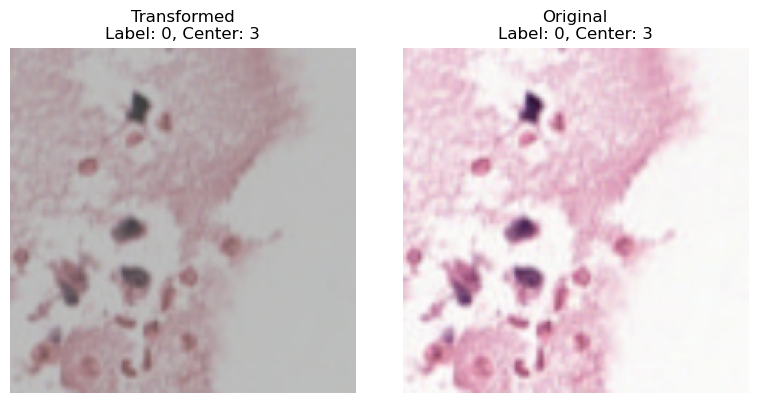

In [ ]:
index = 0

img, label, center = modified_set_3[index]
true_img, true_label, true_center = dummy_set[index]

# Créer les subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Image 1 (ex: transformée)
axes[0].imshow(TF.to_pil_image(img))
axes[0].set_title(f"Transformed\nLabel: {label}, Center: {center}")
axes[0].axis('off')

# Image 2 (ex: image d'origine)
axes[1].imshow(TF.to_pil_image(true_img))
axes[1].set_title(f"Original\nLabel: {true_label}, Center: {true_center}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/162 [00:00<?, ?it/s]

<Axes: title={'center': 'Moyennes des features par centre'}>

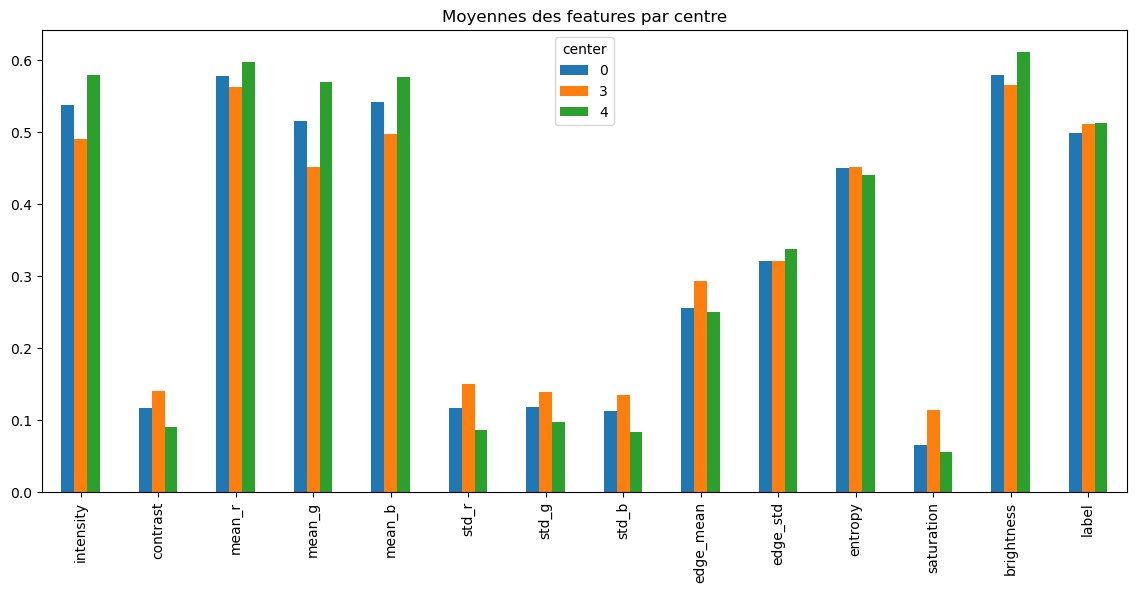

In [ ]:
struct_features_3 = extract_structural_features(train_dataset, batch_size=124, device=device)
struct_features_3.groupby("center").mean().T.plot.bar(figsize=(14,6), legend=True, title="Moyennes des features par centre")

  0%|          | 0/625 [00:00<?, ?batch/s]

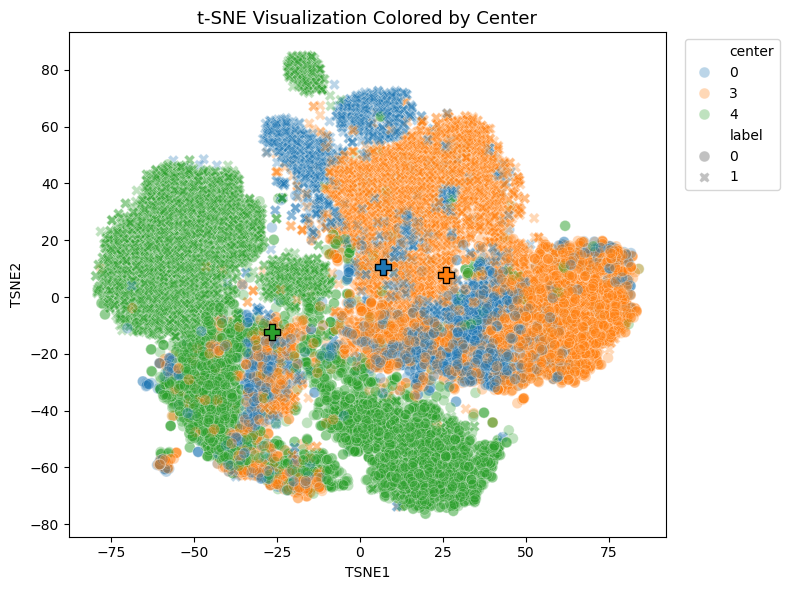

In [ ]:
features_df_3 = get_features_from_model(models.resnet50(weights=models.ResNet50_Weights.DEFAULT),
                            train_dataset,
                            device=device)
plot_tSNE(features_df_3)

### Data transformation \#4